As a junior data scientist at DataVine Analytics, you've been assigned to work with a boutique consulting group that specializes in diverse industry applications of machine learning. Your team serves clients across several sectors, and you've been tasked with developing prototype machine learning solutions using standardized datasets that mirror real-world problems.

Your supervisor has outlined three specific client projects that will test your ability to implement classification, recommendation, and clustering techniques while applying dimensionality reduction and hyper-parameter tuning:

Wine classification system:

A premium wine distributor needs to automatically classify wines based on their chemical properties for inventory management and quality control.

You'll use k-Nearest Neighbors (k-NN) with PCA to create an accurate classification model that can identify wine varieties from their measurable attributes, optimizing the classification through systematic hyperparameter tuning.

Agricultural Feed recommendation engine:

An agricultural supply company wants to recommend similar feed types to farmers based on performance data.

Using the chicken weights dataset as a proxy, you'll build a recommendation system that leverages PCA and similarity metrics to suggest comparable feed products that might produce similar results.

Regional crime pattern analysis:

A public policy research firm requires a data-driven approach to identify patterns in crime statistics across different regions.

You'll apply clustering techniques (both K-Means and Gaussian Mixture Models) to discover natural groupings in crime data, using feature selection and dimensionality reduction to focus on the most relevant patterns.

Follow a standardized data science workflow:

Begin with comprehensive data preparation, ensuring all datasets are properly loaded, cleaned, and standardized.
Apply appropriate dimensionality reduction techniques (PCA) to improve model efficiency and interpretability.
Implement and optimize each machine learning approach (k-NN, recommendation systems, clustering) using best practices for hyper-parameter tuning.
Evaluate and visualize results to extract meaningful insights for stakeholders.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for k-NN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# libraries for recommendation system
from sklearn.metrics.pairwise import cosine_similarity

# libraries for clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# load datasets

# import wine dataset for classification using k-NN
df_wine = pd.read_csv('wine_data.csv', encoding = 'utf-8')

# import agriculture dataset for recommendation systems
df_agri = pd.read_csv('chickwts_data.csv', encoding = 'utf-8')

# import arrests dataset for clustering with k-means and GMM
df_arrests = pd.read_csv('arrests_data.csv', encoding = 'utf-8')

In [3]:
# inspect data for missing values and handle inconsistencies
dfs = [df_wine, df_agri, df_arrests]
df_names = ['Wine', 'Agriculture', 'Arrests']

for name, df in zip(df_names, dfs):
    print(f"\n==== {name} Dataset ====")

    # display basic info about the dataset
    print("\nDataset basic info:\n")
    df.info()

    # check first rows of dataset
    print(f"\nFirst 5 rows:\n{df.head(5)}")

    # check for nulls
    print(f"\nColumns with nulls:\n{df.isnull().sum()}")




==== Wine Dataset ====

Dataset basic info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline           

k-NN (k-Nearest Neighbor) Classification on the Wine Dataset

<Figure size 640x480 with 0 Axes>

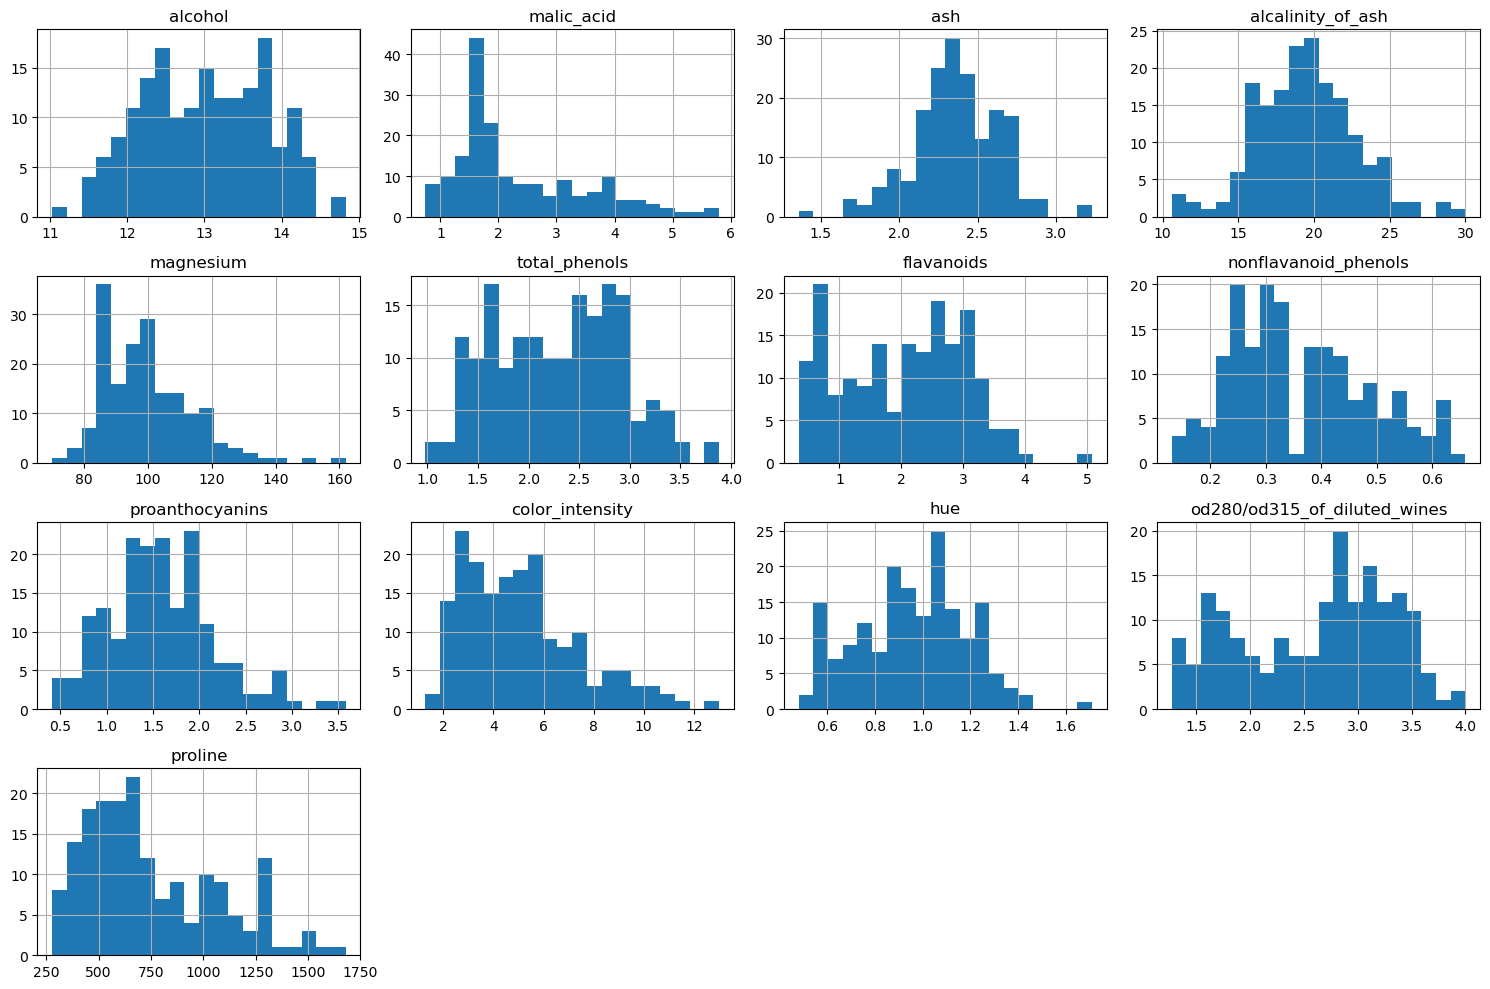

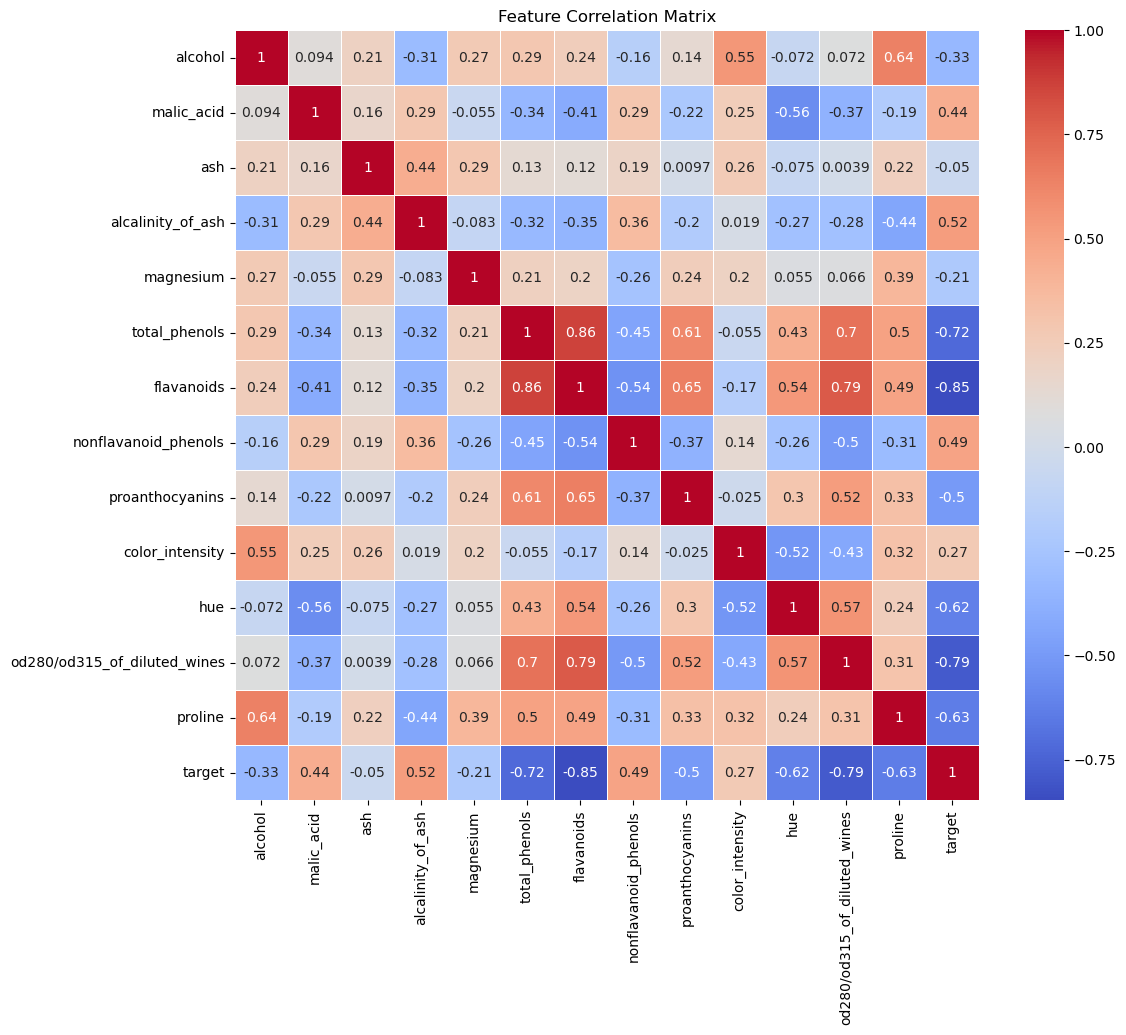

In [4]:
# analyze feature distributions to understand if data needs to be standardized before applying distance metrics

# create histograms of all features to observe their distributions
# select all numeric columns except the target

numeric_columns = [col for col in df_wine.columns if col != 'target']

# plot histograms
plt.figure()
df_wine[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# create a correlation matrix to identify feature relationships
correlation_matrix = df_wine.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

Based on the histograms and correlation matrix, there are features with significantly different scales.
Magnesium and proline are on a different scale from alcohol, alcalinity of ash, and color intensity, which are on different scale from the other features. This would have a significant impact on distance calculations like the Eucliean distance, as features with larger numeric ranges would dominate the distance metric.

There are correlations between features such as proline and color intensity vs. alcohol, flavanoids, proanthocyanins, od of diluted wines, and proline vs. total phenols, and proanthocyanins, hue, and od of diluted wines vs. flavanoids. 
The Mahalanobis distance might be appropriate for a dataset like this with correlated features. 

Before applying k-NN with distance metrics, the data needs to be scaled because Eucliean distance metric is sensitive to scale. 

k-NN Data Preprocessing

In [5]:
# prepare features (X) and target (y)
# drop target from X
X = df_wine.drop('target', axis=1)
y = df_wine['target']

# # split the data into training and testing sets (75-25 split, random state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
# display comparison of original vs scaled data
print("Original first sample:")
print(X_train.iloc[0].values[:5], "...")

print("\nScaled first sample:")
print(X_train_scaled[0][:5], "...")

Original first sample:
[ 13.16   2.36   2.67  18.6  101.  ] ...

Scaled first sample:
[ 0.22632762 -0.02451859  1.10112749 -0.24139362  0.0161012 ] ...


In [7]:
# apply PCA to reduce dimensionality while retaining 95% variance
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of PCA components retained: {pca.n_components_}")

Number of PCA components retained: 10


In [8]:
# implement k-NN with different distance metrics

# distance metrics to X_test
metrics = ['euclidean', 'manhattan', 'chebyshev']
k_value = 5

# dictionary to store results
results = {}

# loop through list of metrics

for metric in metrics:
    # create and evaluate model with different metrics and k=5
    knn = KNeighborsClassifier(n_neighbors=k_value, metric=metric)

    # get cross val scores for model
    cv_scores = cross_val_score(knn, X_train_pca, y_train, cv=5)

    # store the mean of cv scores as value and metric name as key in results dictionary
    results[metric] = cv_scores.mean()

best_metric = max(results, key=results.get)

# find the best metric
print(results)

print(f"\nBest metric: {best_metric} with accuracy: {results[best_metric]:.4f}")

{'euclidean': 0.9478632478632478, 'manhattan': 0.93988603988604, 'chebyshev': 0.9401709401709402}

Best metric: euclidean with accuracy: 0.9479


In [9]:
# implement mahalanobis distance

# calculate covariance matrix from the training data
cov = np.cov(X_train_pca, rowvar=False)
metric_params = {'V': cov}

# implement k-NN with Mahalanobis distance and k=5
knn_mahalanobis = KNeighborsClassifier(metric='mahalanobis', metric_params=metric_params)

# evaluate performance via cross validation
cv_scores_mahalanobis = cross_val_score(knn_mahalanobis, X_train_pca, y_train, cv=5)
results['mahalanobis'] = cv_scores_mahalanobis.mean()

print(f"Average CV accuracy with Mahalanobis: {cv_scores_mahalanobis.mean():.4f}")

# update best metric if necessary
if results['mahalanobis'] > results[best_metric]:
    best_metric = 'mahalanobis'
    print(f"Best new metric {best_metric} with accuracy: {results[best_metric]:.4f}")
else:
    print(f"Best new metric is still {best_metric}")

Average CV accuracy with Mahalanobis: 0.8946
Best new metric is still euclidean


In [10]:
# hyperparameter tuning
# optimize the model by finding the best k value and weighting scheme for the top-performing distance metric

# define parameter grid
param_grid = {
    'n_neighbors': list(range(1,10,2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'algorithm': ['auto']
}

# create base model with best metric
base_model = KNeighborsClassifier()

# initialize and run grid search
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# get best parameters and accuracy
best_params = grid_search.best_params_
best_cv_accuracy = grid_search.best_score_

Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9550


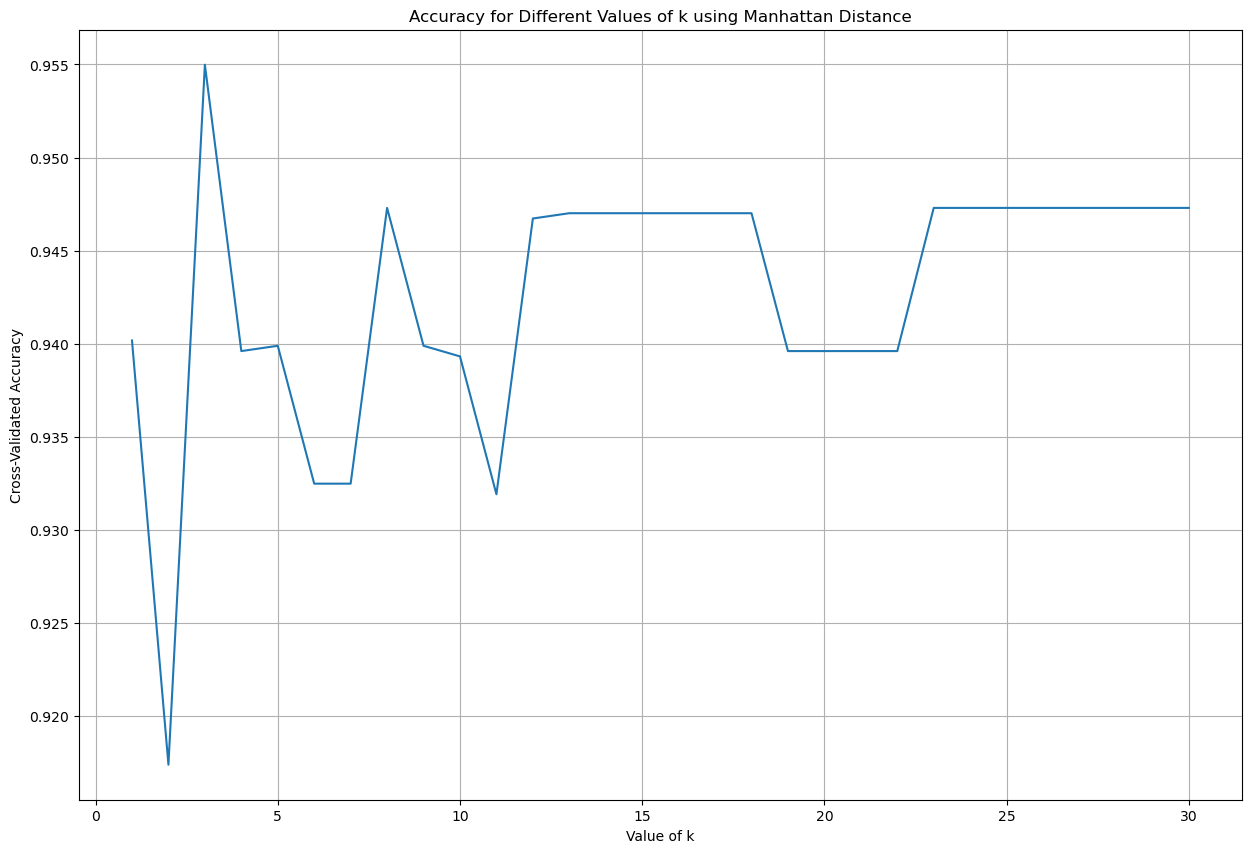

In [11]:
# visualization of accuracy for different k values
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'manhattan')
    scores = cross_val_score(knn, X_train_pca, y_train, cv=5)
    k_scores.append(scores.mean())

plt.figure(figsize=(15,10))
plt.plot(k_range, k_scores)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validated Accuracy')
plt.title(f'Accuracy for Different Values of k using Manhattan Distance')
plt.grid(True)
plt.show()

Best metric changed from euclidean to manhattan based on cross validation performance. Best k new neighbors landed on 3, confirmed by accuracy plot as k=3 results in the highest accuracy of ~0.955.

Test set accuracy: 0.9556

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.89      0.94        18
           2       0.92      1.00      0.96        12

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



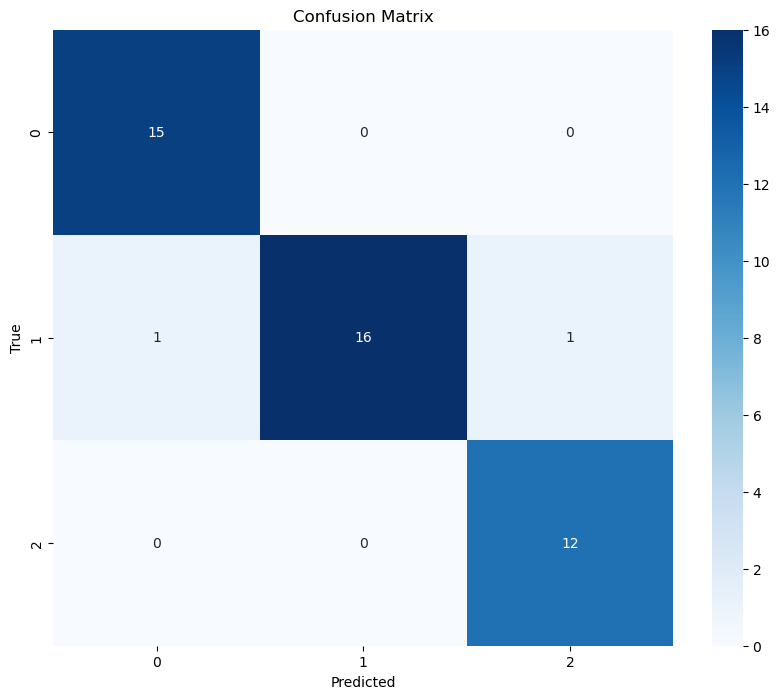

In [12]:
# final model evaluation
# build final model with best parameters

final_model = grid_search.best_estimator_

# make predictions on test set
y_pred = final_model.predict(X_test_pca)

# calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The final k-NN classification model, optimized with PCA and hyperparameter tuning, achieve a test set accuracy of 95.56%, indicating strong generalization performance on unseen wine samples. The classification report shows high precision and recall across all classes. This confirms the model's effectiveness in distinguishing between different wine types based on the different features.

Build a recommendation system using the chickwts dataset

In [13]:
# examine chickwts dataset
print(df_agri.head())
print(df_agri.shape)

           feed_name  proteinContent  fatContent  fiberContent  \
0          FirstPeck            19.5         3.2           2.4   
1    ChickStart Plus            18.2         3.8           3.9   
2  EarlyGrow Formula            19.3         4.6           3.2   
3  HatchMate Premier            20.2         3.7           3.8   
4        PeepNourish            19.2         3.9           4.2   

   calciumContent  phosphorusContent  moistureContent  ashContent  \
0            0.82               0.78             10.8         4.5   
1            3.02               0.68              9.3         6.9   
2            1.20               0.69             10.2         5.8   
3            3.16               0.63             11.4         5.7   
4            3.06               0.61              9.3         5.9   

   metabolizableEnergy  lysineContent  methionineContent  particleSize  \
0                 2921           0.96               0.43           3.5   
1                 2865           0.99   

Number of feed types: 100


<Figure size 640x480 with 0 Axes>

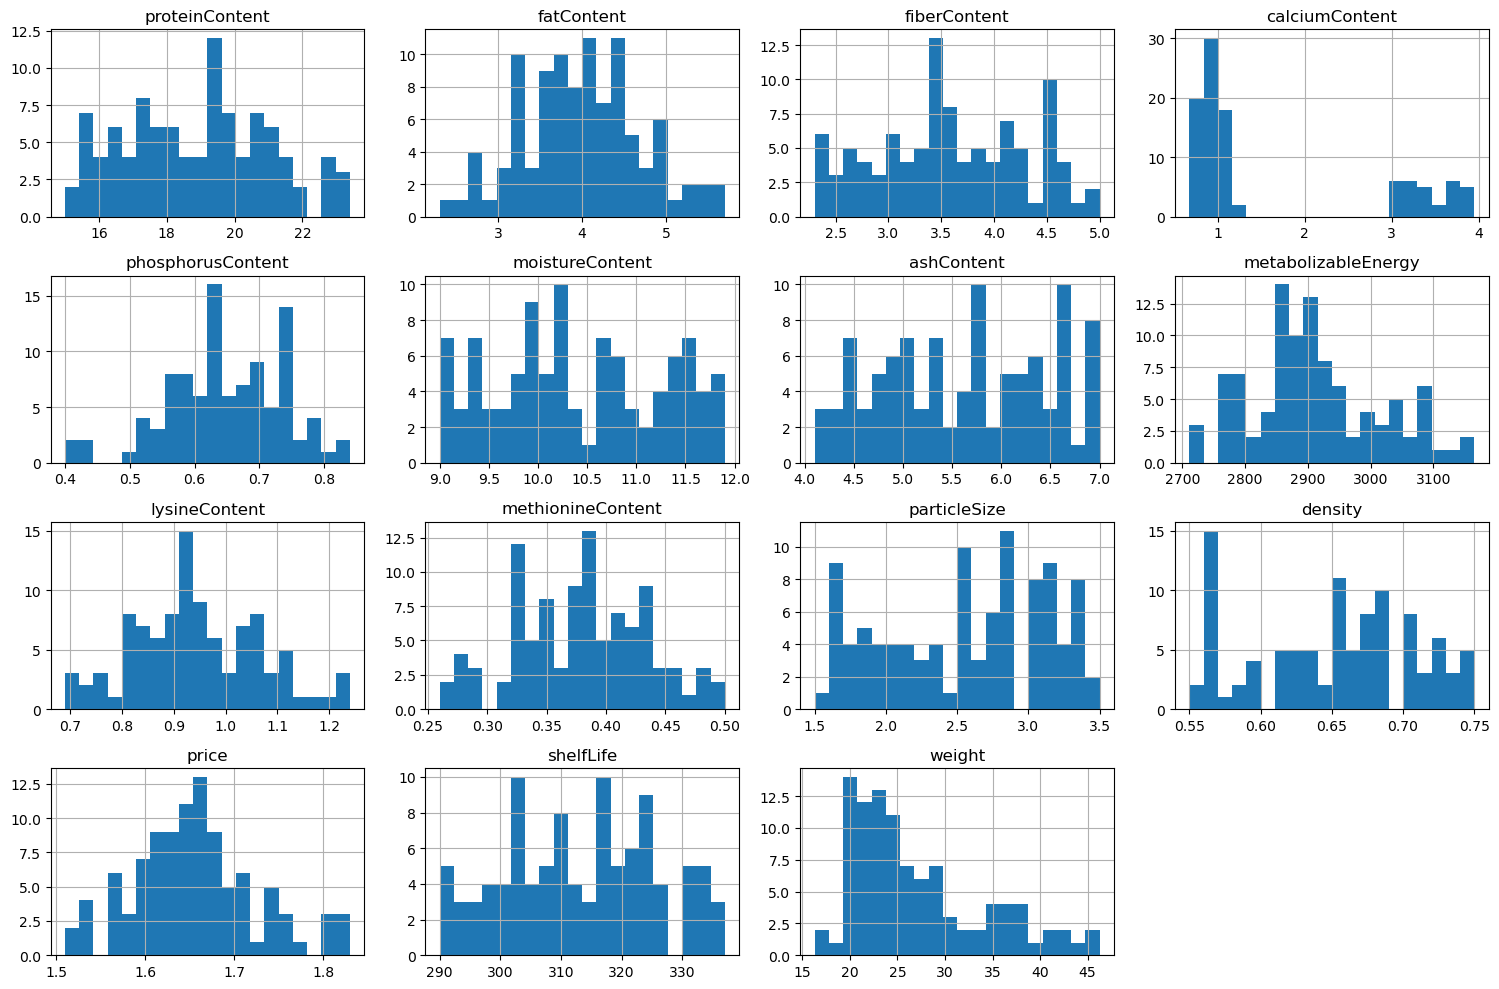

In [14]:
# basic statistics about the dataset
print(f"Number of feed types: {len(df_agri['feed_name'].unique())}")

# create histograms of all features to observe their distributions
# select all numeric columns except the feed name
numeric_columns = [col for col in df_agri.columns if col != 'feed_name']

# plot histograms
plt.figure()
df_agri[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# # create a correlation matrix to identify feature relationships
# correlation_matrix = df_agri.corr()

# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Feature Correlation Matrix')
# plt.show()

In [15]:
# drop non-numeric identifiers
df_agri_features = df_agri.drop(columns='feed_name')

# standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_agri_features)

# apply PCA to reduce dimensions, PCA=0.95 to explain at leaset 95% of variance in data
pca = PCA(n_components = 1)
features_pca = pca.fit_transform(features_scaled)
print(f"Number of principal components retained: {pca.n_components_}")

# create feature matrix 
feature_matrix = features_pca

# calculate cosine similarity between all pairs of feeds
similarity_matrix = cosine_similarity(feature_matrix)

# function to get feed recommendations based on feature similarity

def recommend_similar_feed(feed_name, n=2):
    # find the feed
    feed_names = df_agri['feed_name'].values

    # Find the first occurrence of the given feed name
    try:
        feed_idx = np.where(feed_names == feed_name)[0][0]
    except IndexError:
        return f"Feed '{feed_name}' not found."
    
    # get similarity scores for this feed with all others
    feed_similarities = similarity_matrix[feed_idx]

    # Sort feed by similarity (excluding the feed itself)
    similar_indices = np.argsort(feed_similarities)[::-1][1:n+1]

    # Return similar feed names and their similarity scores
    return pd.DataFrame({
        'Similar_Feed': feed_names[similar_indices],
        'Similarity_Score': feed_similarities[similar_indices]
    })

for feed in df_agri['feed_name']:
    print(f"\nIf {feed} is sold out at the store, consider these feeds with similar nutrition profiles:\n")
    similar_feeds = recommend_similar_feed(feed, n=5)
    print(similar_feeds['Similar_Feed'].to_string(index=False))

Number of principal components retained: 1

If FirstPeck is sold out at the store, consider these feeds with similar nutrition profiles:

     EggMaster Premium
    FastFinish Formula
BroilerCharge Complete
     BroilerBulk Ultra
     MeatMaker Premium

If ChickStart Plus is sold out at the store, consider these feeds with similar nutrition profiles:

       BabyBirdBlend
PulletFirst Complete
   FinishPro Supreme
 GrowStrong Advanced
  MeatYield Advanced

If EarlyGrow Formula is sold out at the store, consider these feeds with similar nutrition profiles:

     EggMaster Premium
    FastFinish Formula
BroilerCharge Complete
     BroilerBulk Ultra
     MeatMaker Premium

If HatchMate Premier is sold out at the store, consider these feeds with similar nutrition profiles:

     EggMaster Premium
    FastFinish Formula
BroilerCharge Complete
     BroilerBulk Ultra
     MeatMaker Premium

If PeepNourish is sold out at the store, consider these feeds with similar nutrition profiles:

       B

Clustering (k-means & GMM) for USArrests 


In [16]:
# inspect arrests df
print(df_arrests.head())
print(df_arrests.info())
df_arrests.shape



   Unnamed: 0  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None


(50, 5)

In [17]:
# rename column with states and set it as the index
df_arrests.rename(columns={'Unnamed: 0': 'State'}, inplace=True)
df_arrests.set_index('State', inplace=True)

# Confirm states column has been moved to index
print(df_arrests.head())

            Murder  Assault  UrbanPop  Rape
State                                      
Alabama       13.2      236        58  21.2
Alaska        10.0      263        48  44.5
Arizona        8.1      294        80  31.0
Arkansas       8.8      190        50  19.5
California     9.0      276        91  40.6


In [18]:
# remove negative or zero values (outliers)
mar = df_arrests[(df_arrests['Murder'] > 0) & (df_arrests['Assault'] > 0) & (df_arrests['Rape'] > 0)]

# drop urbanpop from the df to keep to the top 3 features, as its not a direct measure of crime
mar = mar.drop(columns=['UrbanPop'])

# check shape of df_arrests
print(mar.shape)

# scale features so that features with larger values don't influence those with smaller values
scaler = StandardScaler()
mar_scaled = scaler.fit_transform(mar)

# initialize PCA with 2 principal components
pca = PCA(n_components=2)
arrests_pca = pca.fit_transform(mar_scaled)

arrests_pca.shape

(50, 3)


(50, 2)

In [19]:
# determine optimal clusters for K-means (elbow method)

# WCSS for k-means
wcss = []
k_values = range(1, 10)

# for loop
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state=42, n_init=10)
    kmeans.fit(mar_scaled)
    wcss.append(kmeans.inertia_)

# WCSS
print(f"Mean of WCSS: {round(np.mean(wcss), 2)}")


c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Mean of WCSS: 41.64


c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


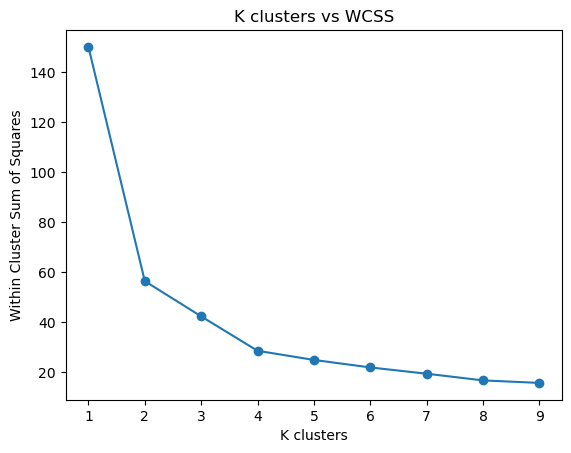

In [20]:
# Plot Elbow Method to determine the optimal number of clusters, k, for K-means
plt.figure()
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel('K clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('K clusters vs WCSS')
plt.show()

The elbow point where the drop in WCSS starts to level off is 2, the candidate for the best k number of clusters

In [21]:
# determine optimal clusters for GMM (AIC and BIC)

# initialize empty lists for bic_scores and aic_scores
bic_scores = []
aic_scores = []

# for loop for k values from 1-9
k_values = range(1, 10)

# compute and return, train a gaussian mixture model
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(arrests_pca)

    bic_scores.append(gmm.bic(arrests_pca))
    aic_scores.append(gmm.aic(arrests_pca))

c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

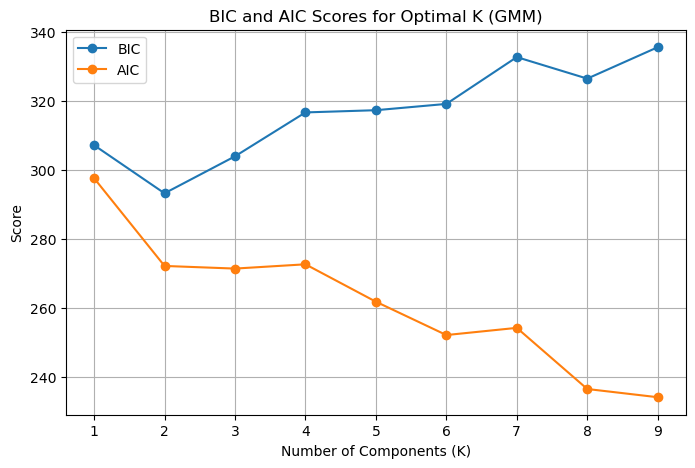

In [22]:
# Plot k_values vs AIC/BIC for GMM
plt.figure(figsize=(8,5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-', label='BIC')
plt.plot(k_values, aic_scores, marker='o', linestyle='-', label='AIC')
plt.xlabel("Number of Components (K)")
plt.ylabel("Score")
plt.legend()
plt.title("BIC and AIC Scores for Optimal K (GMM)")
plt.grid(True)
plt.show()

use k=2 when looking at BIC curve. K is best at 2, before it goes up consistently

In [23]:
# apply clustering models

# optimal k = 2 based on elbow and bic
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
mar['KMeans_Cluster'] = kmeans.fit_predict(arrests_pca)

gmm = GaussianMixture(n_components = optimal_k, random_state=42, n_init=10)
gmm.fit(arrests_pca)
mar['GMM_Cluster'] = gmm.predict(arrests_pca)
mar['GMM_Probability'] = gmm.predict_proba(arrests_pca).max(axis=1)

# silhouette scores to measure how well separated and compact clusters are
silhouette_kmeans = silhouette_score(arrests_pca, mar['KMeans_Cluster'])
silhouette_gmm = silhouette_score(arrests_pca, mar['GMM_Cluster'])

print(f"Silhouette score for kmeans: {round(silhouette_kmeans, 4)}")
print(f"Silhouette score for gmm: {round(silhouette_gmm, 4)}")


Silhouette score for kmeans: 0.568
Silhouette score for gmm: 0.561


c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jtlee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Kmeans has a slightly better silhouette score, meaning the clusters are more compact than that of gmm

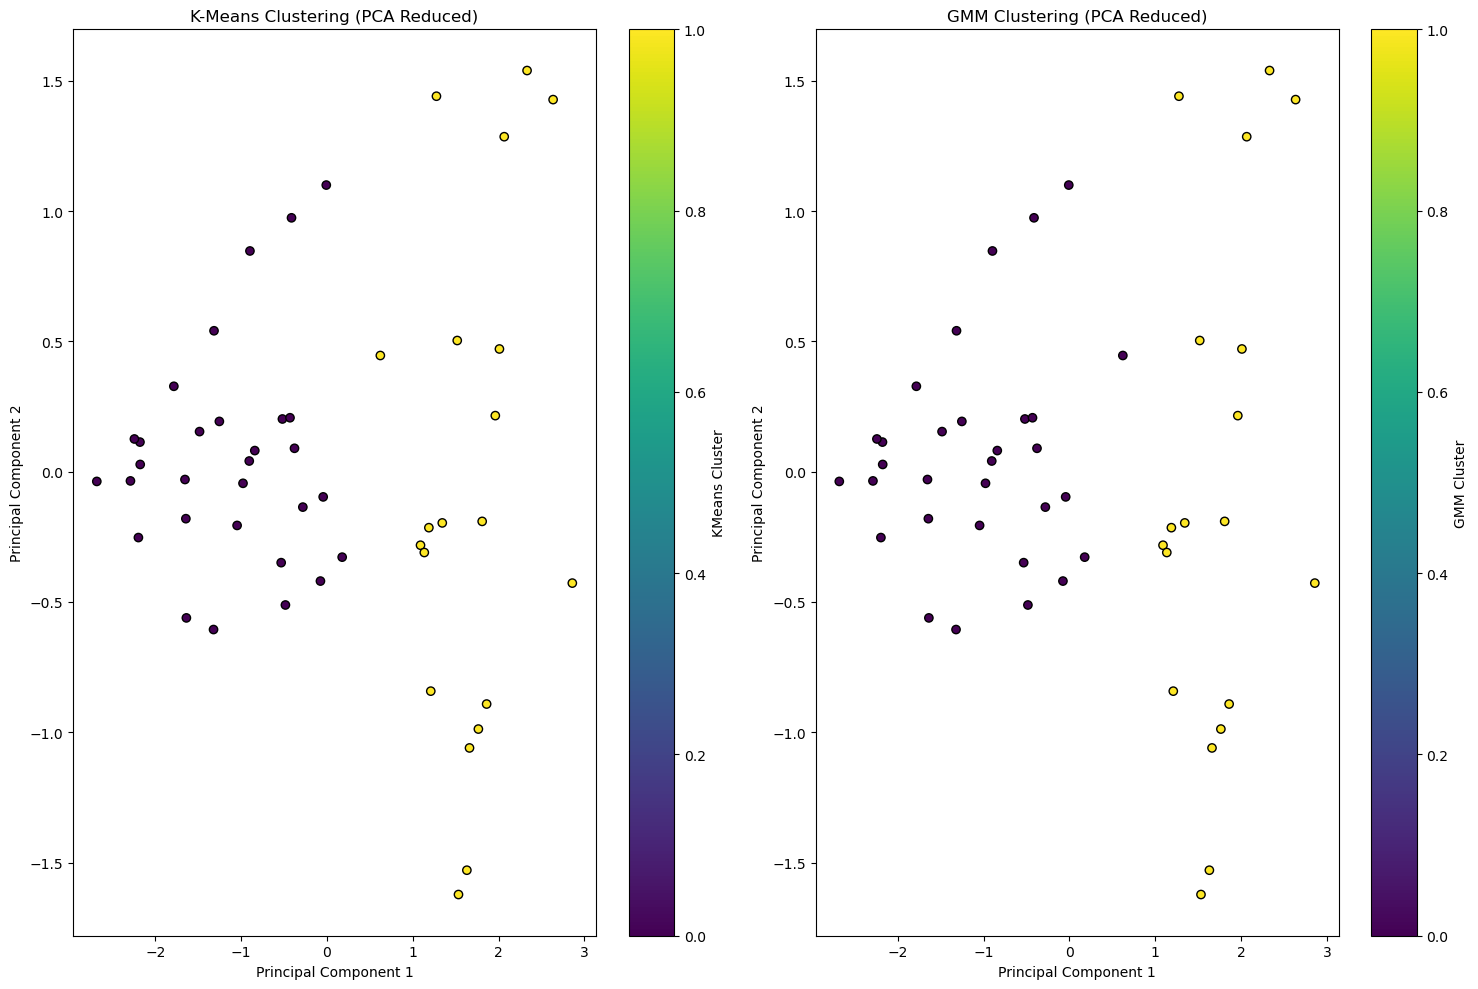

In [24]:
# visualize and compare clustering results 

# create 2 scatter plots

# create subplots
fig, axes = plt.subplots(1,2, figsize=(15,10))

# k-means clustering plot
scatter = axes[0].scatter(arrests_pca[:,0], arrests_pca[:,1], c=mar['KMeans_Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.colorbar(scatter, ax=axes[0], label='KMeans Cluster')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].set_title('K-Means Clustering (PCA Reduced)')

# gmm clustering plot
scatter = axes[1].scatter(arrests_pca[:, 0], arrests_pca[:, 1], c=mar["GMM_Cluster"], cmap='viridis', marker='o', edgecolor='k', label='Cluster')
plt.colorbar(scatter, ax=axes[1], label='GMM Cluster')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('GMM Clustering (PCA Reduced)')

# Show the plots
plt.tight_layout()

plt.show()

In [25]:
# Create a DataFrame from PCA results and restore index
pca_df = pd.DataFrame(arrests_pca, columns=["PC1", "PC2"], index=mar.index)

# Add cluster assignments
pca_df["KMeans_Cluster"] = mar["KMeans_Cluster"]
pca_df["GMM_Cluster"] = mar["GMM_Cluster"]
pca_df["GMM_Probability"] = mar["GMM_Probability"]

# View first few rows
print(pca_df)

                     PC1       PC2  KMeans_Cluster  GMM_Cluster  \
State                                                             
Alabama         1.210191 -0.842277               1            1   
Alaska          2.332187  1.539434               1            1   
Arizona         1.518593  0.503363               1            1   
Arkansas        0.177776 -0.328029               0            0   
California      2.066000  1.285497               1            1   
Colorado        1.276240  1.440888               1            1   
Connecticut    -1.643583 -0.180417               0            0   
Delaware       -0.075572 -0.419830               0            0   
Florida         2.859470 -0.427616               1            1   
Georgia         1.861048 -0.891736               1            1   
Hawaii         -1.315626  0.540721               0            0   
Idaho          -1.484140  0.153802               0            0   
Illinois        1.090540 -0.282248               1            

In [26]:
# Create a boolean mask where cluster labels differ
mismatch_mask = mar['KMeans_Cluster'] != mar['GMM_Cluster']

# Filter states with different cluster assignments
cluster_disagreements = mar[mismatch_mask]

# Show the relevant columns (State is the index)
print(cluster_disagreements[['KMeans_Cluster', 'GMM_Cluster']])

          KMeans_Cluster  GMM_Cluster
State                                
Missouri               1            0


Both K-Means and GMM produced highly consistent clustering results when applied to the PCA reducecd crime dataset.
Out of all the states analyzed, only one state Missouri, was assigned to different clusters by the 2 algorithms.This suggests that both methods are capturing similar underlying structure in the data, with Missouri likely lying near the decision boundary between clusters.